In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from stop_iter import stop_iter
import jax
from functools import partial

dataset: str = "moons"
dataset_size = 2_000
prior_distribution = partial(jax.random.truncated_normal, lower=-2.0, upper=2.0)


if dataset == "moons":
    X, y = make_moons(n_samples=dataset_size, noise=0.1, random_state=0)
elif dataset == "blobs":
    X = make_blobs(n_samples=dataset_size, centers=6, cluster_std=0.5, random_state=6)[0]
elif dataset == "face":
    complex_points = np.exp(1j * np.random.rand(dataset_size) * 2 * np.pi)
    X = np.stack((complex_points.real, complex_points.imag)).T
    upper = complex_points.imag > 0
    left = complex_points.real < 0
    X[upper, 1] = 0.5
    X[upper & left, 0] = -0.5
    X[upper & ~left, 0] = 0.5
    noise = np.zeros_like(X)
    noise[upper] = np.random.randn(*noise[upper].shape) * 0.10
    noise[~upper] = np.random.randn(*noise[~upper].shape) * 0.05
    X += noise
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    X = X + noise
else:
    raise ValueError(f"Unknown dataset: {dataset}")

X = MinMaxScaler((-1, 1)).fit_transform(X)

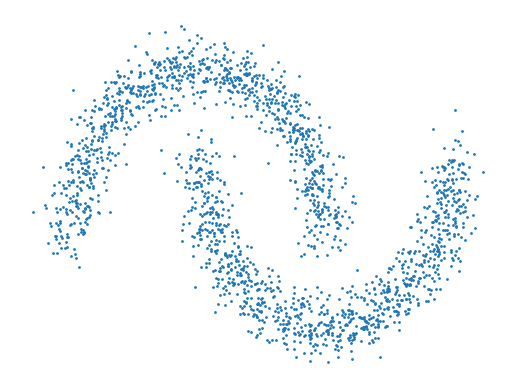

In [4]:
# x_min, x_max, y_min, y_max = X[:, 0].min() * 1.2, X[:, 0].max() * 1.2, X[:, 1].min() * 1.2, X[:, 1].max() * 1.2
x_min, x_max, y_min, y_max = -1.2, 1.2, -1.2, 1.2
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.axis("off")
plt.show()

In [7]:

import jax
import jax.numpy as jnp
from flax import nnx


class Flow(nnx.Module):
  def __init__(self, din: int, dim: int, rngs: nnx.Rngs):
    self.din, self.dim = din, dim
    self.linear_in = nnx.Linear(din + 1, dim, rngs=rngs)
    self.blocks = [
      nnx.Linear(dim, dim, rngs=rngs) 
      for _ in range(3)
    ]
    self.linear_out = nnx.Linear(dim, din, rngs=rngs)

  def __call__(self, x, t):
    x = jnp.concatenate([x, t[:, None]], axis=-1)
    x = nnx.gelu(self.linear_in(x))
    for block in self.blocks:
      x = nnx.gelu(block(x)) + x
    x = self.linear_out(x)
    return x
  
data_dim: int = 2
model_dim: int = 64

rngs = nnx.Rngs(0)

flow_model = Flow(data_dim, model_dim, rngs)
pred_flow = flow_model(X[:2], jnp.array([0., 1.]))

nnx.display(flow_model)
print(pred_flow)

[[-0.03552387 -0.07233484]
 [-0.430291   -0.19290365]]


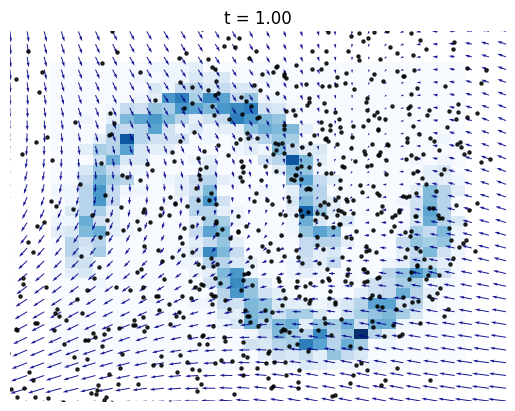

In [8]:
from dyn_plot import Plot
from diffrax import ODETerm, Euler, Dopri5, AbstractSolver


def show_vector_field(ti, plot: Plot):
  # create a meshgrid between -1 and 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=30), np.linspace(y_min, y_max, 30))
  x = np.stack([xx, yy], axis=-1).reshape(-1, 2)
  # get predicted noise predictions, gradient is negative noise
  t = jnp.full(x.shape[0], ti)

  field = flow_model(x, t)
  grad_norm = np.linalg.norm(field, axis=-1, ord=2, keepdims=True)
  grad_log1p = field / (grad_norm + 1e-9) * np.log1p(grad_norm)

  # color dark blue
  plot.quiver(*x.T, *grad_log1p.T, width=0.002, alpha=0.9, color='darkblue')

def simulate_flow(n_steps: int, solver: AbstractSolver, plot: Plot | None = None):
  dt = 1 / n_steps
  x0 = prior_distribution(jax.random.key(0), shape=(dataset_size // 2, data_dim))
  ts = jnp.linspace(0., 1., n_steps)

  flow_model.eval() # we don't really need this here, but in general it would be appropriate
  vector_field = lambda t, x, args: flow_model(x, jnp.full(x.shape[0], t))
  term = ODETerm(vector_field)
  state = solver.init(term, 0.0, dt, x0, None)
  
  @jax.jit
  def _step(x, t, dt, state):
    x, _, _, state, _ = solver.step(term, t, t + dt, x, None, state, made_jump=False)
    return x, state

  xs = [x0]
  x = x0
  for t in ts:
    if plot:
      with plot:
        plot.hist2d(X[:, 0], X[:, 1], bins=30, cmap='Blues')
        show_vector_field(t, plot)
        plot.scatter(x[:, 0], x[:, 1],alpha=0.8, s=5, c='k')
        # set title
        plot.set_title(f"t = {t:.2f}")
        plot.axis("off")
        # set x_lim and y_lim
        plot.set_xlim(x_min, x_max)
        plot.set_ylim(y_min, y_max)

    x, state = _step(x, t, dt, state)
    xs.append(x)

  return xs, ts

plot = Plot()
simulate_flow(20, Euler(), plot=plot)
plot.close()

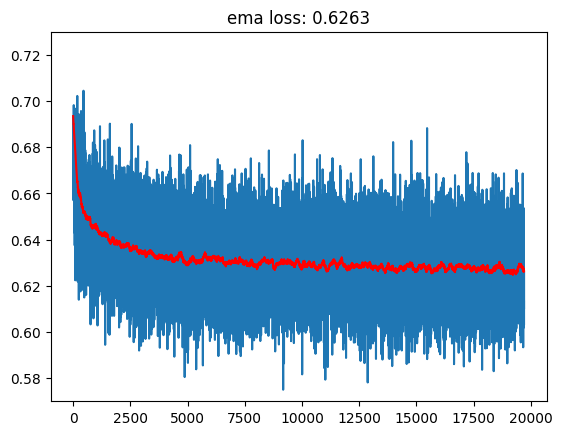

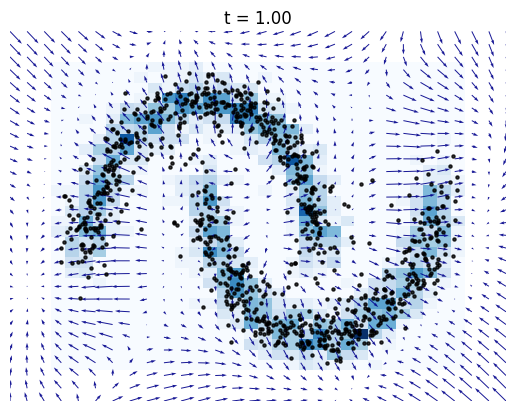

100%|██████████| 20000/20000 [02:06<00:00, 158.67it/s]


In [9]:

import optax

def loss_fn(flow_model: Flow, x, rngs: nnx.Rngs):
  sigma = 1 # - 1e-4
  t = jax.random.uniform(rngs(), (x.shape[0],))
  noise = prior_distribution(rngs(), shape=x.shape)

  x_t = (1 - sigma * t[:, None]) * noise + t[:, None] * x
  optimal_flow = x - sigma * noise
  predicted_flow = flow_model(x_t, t)

  return jnp.mean((predicted_flow - optimal_flow) ** 2)


@nnx.jit
def train_step(flow_model: Flow, optimizer: nnx.Optimizer, x, rngs: nnx.Rngs):
  # print("compiling 'train_step' ...")
  loss, grads = nnx.value_and_grad(loss_fn)(flow_model, x, rngs)
  optimizer.update(grads)
  return loss

tx = optax.adamw(1e-3)
# tx = optax.contrib.schedule_free(optax.adamw(1e-3), 1e-3)

optimizer = nnx.Optimizer(flow_model, tx)

loss_plot = Plot()
simulation_plot = Plot()
losses = []
ema_losses = []
ema_loss = None
for epoch in stop_iter(tqdm(range(20_000))):
  x = X
  loss = train_step(flow_model, optimizer, x, rngs)
  losses.append(np.array(loss))

  if epoch >= 100:
    ema_loss = loss if ema_loss is None else 0.99 * ema_loss + 0.01 * loss
    ema_losses.append(ema_loss)
  
  if epoch % 200 == 0:
    with loss_plot:
      loss_plot.plot(losses[100:])
      loss_plot.plot(ema_losses, color='red')
      if ema_loss is not None:
        loss_plot.set_title(f"ema loss: {ema_loss:.4f}")
      loss_plot.set_ylim(0.57, 0.73)

  if epoch % 2000 == 0:
    simulate_flow(50, Euler(), plot=simulation_plot)

loss_plot.close()
simulation_plot.close()

In [10]:
import matplotlib.animation as animation
from IPython.display import HTML, clear_output

n_steps = 100
plot = Plot()

xs, ts = simulate_flow(n_steps, Dopri5(), plot=plot)

xs += [xs[-1]] * (len(xs) // 5)

def animate(i):
  plot.clear()
  plot.hist2d(X[:, 0], X[:, 1], bins=30, cmap='Blues')
  show_vector_field(ts[i], plot)
  plot.scatter(xs[i][:, 0], xs[i][:, 1], s=2, c="k")
  plot.set_title(f"t = {ts[i]:.2f}")
  plot.axis("off")
  plot.set_xlim(x_min, x_max)
  plot.set_ylim(y_min, y_max)

ani = animation.FuncAnimation(plot.fig, animate, frames=len(xs), interval=50)
html = HTML(ani.to_html5_video())
clear_output()

plot.close()
html